[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/pymc_sdss_2024/blob/master/notebooks/Section3-Bayesian_Computation.ipynb)

# Bayesian Computation

Lets take a look at [Bayes formula](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

We have $P(\theta|x)$, the probability of our model parameters $\theta$ given the data $x$ and thus our quantity of interest. To compute this we multiply the prior $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $P(x|\theta)$, i.e. how we think our data is distributed. This nominator is pretty easy to solve for.

However, lets take a closer look at the denominator. $P(x)$ which is also called the evidence (i.e. the evidence that the data x was generated by this model). We can compute this quantity by integrating over all possible parameter values:
$$P(x) = \int_\Theta P(x, \theta) \, \mathrm{d}\theta$$

This is the key difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute the posterior in a closed-form way. 

## Numerical Integration

Bayesian analysis often requires integration over multiple dimensions that is intractable both via analytic methods or standard methods of numerical integration.
However, it is often possible to compute these integrals by simulating
(drawing samples) from posterior distributions. For example, consider the expected value of a random variable $\mathbf{x}$:

$$E[\mathbf{x}] = \int \mathbf{x} f(\mathbf{x}) d\mathbf{x}, \qquad\mathbf{x} = x_1, \ldots ,x_k$$

where $k$ (the dimension of vector $x$) is perhaps very large. If we can produce a reasonable number of random vectors $\{{\bf x_i}\}$, we can use these values to approximate the unknown integral. This process is known as *Monte Carlo integration*. In general, MC integration allows integrals against probability density functions:

$$I = \int h(\mathbf{x}) f(\mathbf{x}) \mathbf{dx}$$

to be estimated by finite sums:

$$\hat{I} = \frac{1}{n}\sum_{i=1}^n h(\mathbf{x}_i),$$

where $\mathbf{x}_i$ is a sample from $f$. This estimate is valid and useful because:

-   By the strong law of large numbers:

$$\hat{I} \rightarrow I   \text{   with probability 1}$$

-   Simulation error can be measured and controlled:

$$Var(\hat{I}) = \frac{1}{n(n-1)}\sum_{i=1}^n (h(\mathbf{x}_i)-\hat{I})^2$$

And let's assume we could somehow generate samples from this unnormalized distribution. In that case we could approximate the full posterior quite easily:

## Rejection Sampling

Most integrals are hard or impossible to do. Also, if we are iterating on a statistical model, we may want a method that works without requiring rederiving a formula for generating samples. Further, in Bayesian data analysis, we may not know a *normalizing constant*: we may only know 

$$
\tilde{p}(x) = \frac{1}{Z_p}p(x),
$$

for some constant $Z_p$ ("constant" here is with respect to $x$). In order to sample, first we

1. Choose a proposal distribution $q$ that you know how to sample from
2. Choose a number $k$, so that $kq(x) \geq \tilde{p}(x)$ for all $x$

Then, we repeatedly 

1. Draw a $z$ from $q$
2. Draw a $u$ from $\operatorname{Uniform}(0, kq(z))$
3. If $u \leq p(x)$, accept the draw, otherwise, reject.

Importantly, every "rejection" is wasted computation! We will explore methods for having less wasted computation later.

### Example: Mixture of Gaussians

We can sample from the pdf returned by `mixture_of_gaussians` using rejection sampling. We will implement this as a Python generator, and yield the proposed draw, `z`, as well as whether it was accepted. You should assume `proposal_dist` comes from `scipy.stats`, so it has a `.rvs()` method that samples, and a `.pdf` method that evaluates the probability density function at a point.

In [1]:
import scipy.stats as st

def mixture_of_gaussians():
    rvs = (st.norm(-3, 1), st.norm(0, 1), st.norm(3, 1))
    probs = (0.5, 0.2, 0.3)
    def pdf(x):
        return sum(p * rv.pdf(x) for p, rv in zip(probs, rvs))
    return pdf

<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3373359/4088211947.py:16: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(t, k * q.pdf(t), '-', label='$k \cdot \mathcal{N}(z | 0, 3)$')
/tmp/ipykernel_3373359/4088211947.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(z, u, 'rx', label='$u \sim U(0, k\cdot\mathcal{N}(z | 0, 3))$', ms=15, mfc=bg_color)


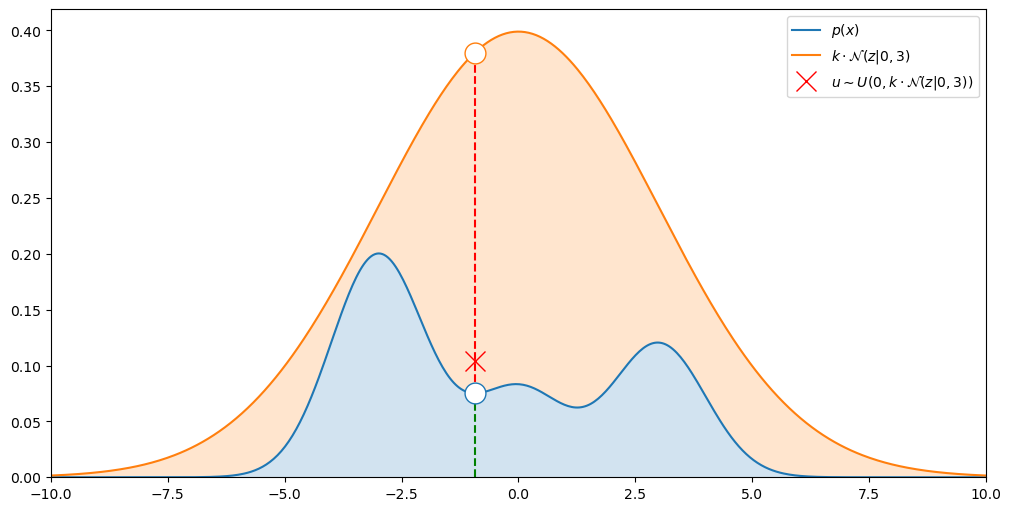

In [2]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(6)
pdf = mixture_of_gaussians()
q = st.norm(0, 3)
z = q.rvs()
u = np.random.rand() * q.pdf(z)
k = 3

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

t = np.linspace(-10, 10, 500)
ax.plot(t, pdf(t), '-', label='$p(x)$')
ax.fill_between(t, 0, pdf(t), alpha=0.2)
ax.plot(t, k * q.pdf(t), '-', label='$k \cdot \mathcal{N}(z | 0, 3)$')
ax.fill_between(t, pdf(t), k * q.pdf(t), alpha=0.2)

bg_color = ax.get_facecolor()
ax.vlines(z, 0, pdf(z), linestyles='dashed', color='green')
ax.vlines(z, pdf(z), k * q.pdf(z), linestyles='dashed', color='red')

# ax.plot(z, 0, 'o', label='z', ms=15, mfc=bg_color)
ax.plot(z, pdf(z), 'o', color='C0', ms=15, mfc=bg_color)
ax.plot(z, u, 'rx', label='$u \sim U(0, k\cdot\mathcal{N}(z | 0, 3))$', ms=15, mfc=bg_color)
ax.plot(z, k * q.pdf(z), 'o', color='C1', ms=15, mfc=bg_color)

# ax.plot(z * np.ones(4), np.array([0, pdf(z), u, k * q.pdf(z)]), 'ko', ms=15, mfc=bg_color)

ax.set_ylim(bottom=0)
ax.set_xlim(t.min(), t.max())
ax.legend()

> #### What is a Generator?
> A Python generator is a special type of iterator that allows you to iterate over a sequence of values lazily, meaning it generates values on-the-fly and only when requested, rather than storing the entire sequence in memory. This is accomplished using the `yield` statement within a function, which produces a value and pauses the function's execution, resuming from that point when the next value is requested. Thus, instead of generating and storing all values at once, which can be resource-intensive, generators produce values one at a time, thus reducing memory overhead and allowing for the handling of infinite sequences or very large data sets that would be impractical to store in memory. 

If $kq(x)$ is not larger than $\tilde{p}(x)$, throw an exception!

The cell below has a plot to check your implementation.

In [3]:
# Rejection sampler code here
def rejection_sampler(pdf, proposal_dist, k):
    while True:
        # Generate proposal
        z = proposal_dist.rvs()
        q_dist = proposal_dist.pdf(z)
        # Draw uniformly from 0 to k * q(z)
        u = k * np.random.rand() * q_dist
        # Check our envelope condition
        assert k * q_dist >= pdf(z)
        if u <= pdf(z):
            accept = True
        else:
            accept = False
        yield z, accept

def gen_samples(draws, sampler):
    samples = []
    for n_draws, (z, accept) in enumerate(sampler, start=1):
        if accept:
            samples.append(z)
            if len(samples) == draws:
                return np.array(samples), n_draws

In [4]:
pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 3)
k = 4
N = 10_000

samples, draws = gen_samples(N, rejection_sampler(pdf, proposal_dist, k))

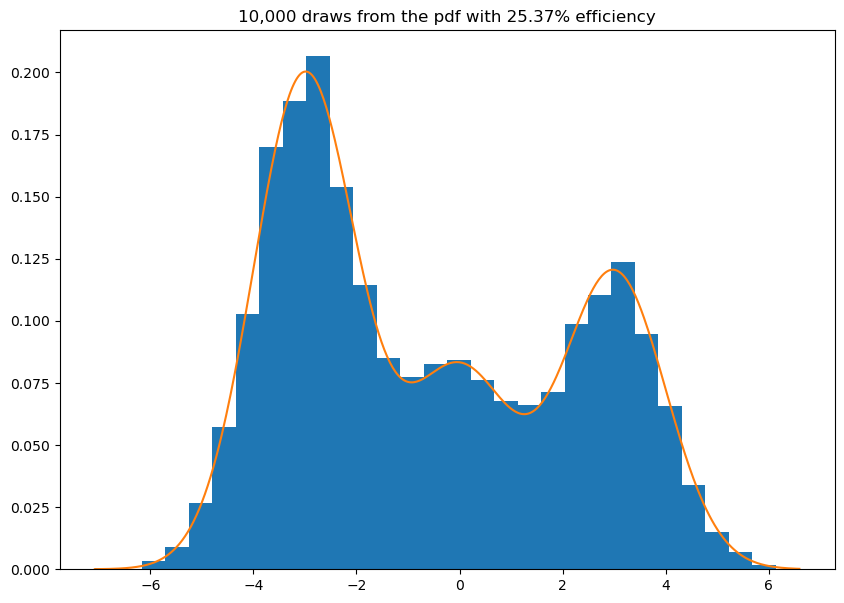

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(samples.min(), samples.max(), 500)

# This histogram should look very similar to the pdf that is plotted
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * samples.size / draws:.2f}% efficiency');

### Exercise: How does a rejection sampler scale with dimension?

Use as your "unknown distribution" a multivariate Gaussian with identity covariance matrix, and use as your proposal distribution a multivariate Gaussian with covariance matrix `1.1 * I`. 

- Around what percent of samples are accepted with dimension 1? 
- 10 dimensions? 
- 100 dimensions? 
- What happens if you try to use 1,000 dimensions?

In [6]:
from itertools import takewhile

DIM = 100

def finite_sampler(attempts, sampler):
    samples = []
    for n_draws, (z, accept) in takewhile(lambda j: j[0] < attempts, enumerate(sampler)):
        if accept:
            samples.append(z)
    return np.array(samples)        

pdf = st.multivariate_normal(np.zeros(DIM), np.eye(DIM)).pdf
proposal_dist = st.multivariate_normal(np.zeros(DIM), 1.1 * np.eye(DIM))
k = pdf(0) / proposal_dist.pdf(0)

sampler = rejection_sampler(pdf, proposal_dist, k)

samples = finite_sampler(1_000, sampler)

len(samples) / 1000

0.008

## Introduction to MCMC

One way to intuitively waste less computation is to use knowledge from your current sample to inform your next proposal: this is called a *Markov chain*. 


> ## Markov Chains
>
> A Markov chain is a special type of *stochastic process*. The standard definition of a stochastic process is an ordered collection of random variables:
>
> $$\{X_t: t \in T\}$$
> 
> where $t$ is frequently (but not necessarily) a time index. If we think of $X_t$ as a state $X$ at time $t$, and invoke the following dependence condition on each state:
> 
> $$Pr(X_{t+1}=x_{t+1} | X_t=x_t, X_{t-1}=x_{t-1},\ldots,X_0=x_0) = Pr(X_{t+1}=x_{t+1} | X_t=x_t)$$
> 
> then the stochastic process is known as a Markov chain. This conditioning specifies that the future depends on the current state, but not past states.



Let $t$ be the index of our current sample, $x_t$ be our current sample, and $\operatorname{pdf}(x_t)$ be our probability density function evaluated at the current sample. We will define a *transition probability* that is conditioned on our current position: $T(x_{t + 1} | x_t)$. It turns out that a Markov chain will sample from $\operatorname{pdf}$ if:

- $T$ is ergodic (sort of techinical -- roughly $T$ is aperiodic and can explore the whole space)
- The chain satisfies *detailed balance*, which means $\operatorname{pdf}(x_t)T(x_{t+1} | x_t) = \operatorname{pdf}(x_{t + 1})T(x_{t} | x_{t + 1})$.

This second criteria inspires the *Metropolis acceptance criteria*: If we use any proposal with density function $\operatorname{prop}$, we use this criterion to "correct" the transition probability to satisfy detailed balance:

$$
A(x_{t + 1} | x_t) = \min\left\{1, \frac{\operatorname{pdf}(x_{t + 1})}{\operatorname{pdf}(x_{t})}\frac{\operatorname{prop}(x_{t} | x_{t + 1})}{\operatorname{prop}(x_{t + 1} | x_t)} \right\}
$$

Now the *Metropolis-Hastings Algorithm* is

Initialize at some point $x_0$. For each iteration:

1. Draw $\tilde{x}_{t + 1} \sim \operatorname{prop}(x_t)$
2. Draw $u \sim \operatorname{Uniform}(0, 1)$
3. If $u < A(\tilde{x}_{t + 1} | x_t)$, then $x_{t + 1} = \tilde{x}_{t + 1}$. Otherwise, $x_{t + 1} = x_t$.

In [7]:
def metropolis_hastings(pdf, prop_dist, init=0):
    """Yields a sample, and whether it was accepted. Notice that,
    unlike the rejection sampler, even when the second argument is `False`,
    we use the sample! 
    """
    current = init
    while True:
        prop = prop_dist.rvs()
        p_accept = min(1, pdf(prop) / pdf(current) * prop_dist.pdf(current) / prop_dist.pdf(prop))
        accept = np.random.rand() < p_accept
        if accept:
            current = prop
        yield current, accept
        
def gen_samples(draws, sampler):
    """An example of using the metropolis_hastings API."""
    samples = np.empty(draws)
    accepts = 0
    for idx, (z, accept) in takewhile(lambda j: j[0] < draws, enumerate(sampler)):
        accepts += int(accept)
        samples[idx] = z
    return samples, accepts


This is "tested" in the following cell.

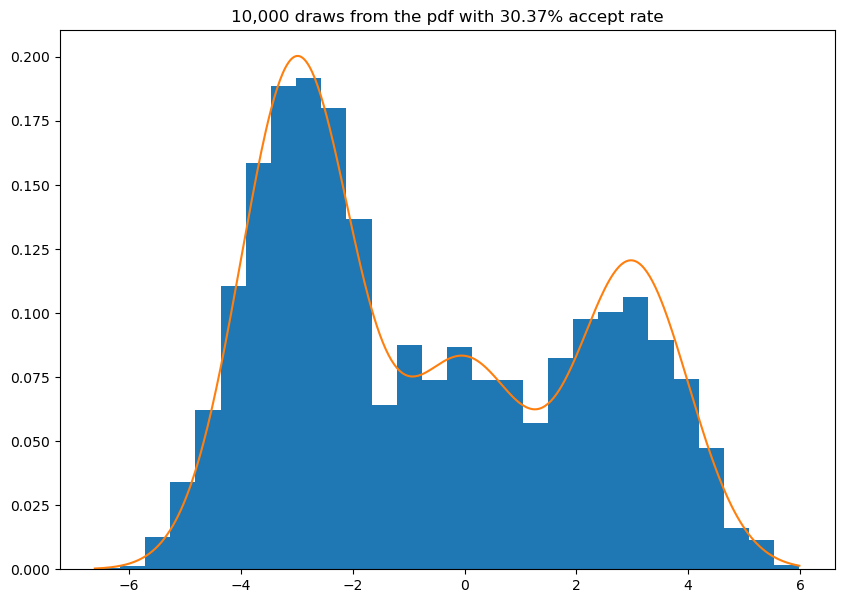

In [8]:
pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 10)

samples, accepts = gen_samples(10_000, metropolis_hastings(pdf, proposal_dist))

fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(samples.min(), samples.max(), 500)
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * accepts / samples.size :.2f}% accept rate');

### Exercise: Random Walk Metropolis-Hastings

This implementation is wildly inefficient! We will speed it up by fixing the proposal distribution as a Gaussian centered at the previous point (this is fairly standard). Specifically,
$$x_{t+1} \sim \mathcal{N}( x_t, \sigma),$$
so
$$\operatorname{prop}(x_{t+1} | x_{t}) = \mathcal{N}(x_{t + 1} | x_t, \sigma)$$

We call $\sigma$ the *step size*.

1. The Metropolis-Hastings acceptance criteria simplifies quite a bit - work out what $A(x_{t + 1} | x_t)$ is now.
2. scipy.stats is doing a lot of work: `st.norm().rvs()` is ~1000x slower than `np.random.randn()`. Rewrite `metropolis_hastings` with the acceptance criteria, and without using `st.norm().rvs()` to provide proposals.

In [9]:
# Write your answer here

### MCMC Exercises 2

1. Find a step size so that the acceptance rate is ~25%
2. Find a step size so that the acceptance rate is ~95%
3. What is the general relationship between step size and acceptance rate?

### Bonus exercise

Write a routine for finding a step size that gives a specific acceptance rate for Metropolis-Hastings. It may be helpful to return the acceptance probability instead of (or in addition to) the `accept` boolean. Literature suggests the overly specific 23.4% acceptance rate as a good target. PyMC aims for anything between 20% and 50%.

## Gibbs Sampling

If you can sample from all the marginal distributions, you can implement a sampler pretty efficiently just using those.

Here is a stereotypical Gibbs sampling algorithm:

1.  Choose starting values for states (parameters):
    ${\bf \theta} = [\theta_1^{(0)},\theta_2^{(0)},\ldots,\theta_k^{(0)}]$

2.  Initialize counter $j=1$

3.  Draw the following values from each of the $k$ conditional
    distributions:

$$\begin{aligned}
\theta_1^{(j)} &\sim& \pi(\theta_1 | \theta_2^{(j-1)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\theta_2^{(j)} &\sim& \pi(\theta_2 | \theta_1^{(j)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\theta_3^{(j)} &\sim& \pi(\theta_3 | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\vdots \\
\theta_{k-1}^{(j)} &\sim& \pi(\theta_{k-1} | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_k^{(j-1)}) \\
\theta_k^{(j)} &\sim& \pi(\theta_k | \theta_1^{(j)},\theta_2^{(j)},\theta_4^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_{k-1}^{(j)})
\end{aligned}$$

4.  Increment $j$ and repeat until convergence occurs.

This is pretty tricky to automate, since you need to know all of these conditional distributions! That said, this is often seen in science when a sampler is hand-built to do inference with a specific model. In that case, each conditional distribution might be computed by hand.

### Coal mining example
We have a time series of recorded coal mining disasters in the UK from 1851 to 1961.

Occurrences of disasters in the time series is thought to be derived from a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.


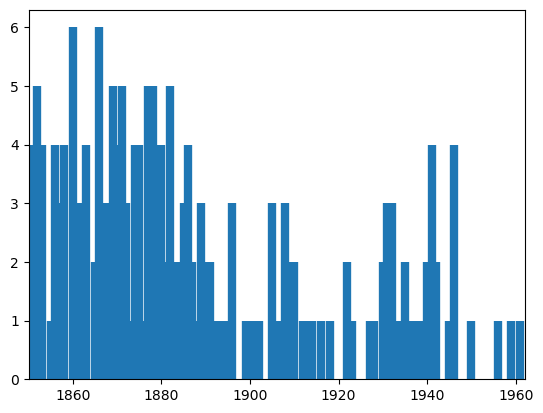

In [10]:
disasters_array = np.array(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 
     1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 
     1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 
     0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 
     1, 2, 4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 
     1])
years = np.arange(1851, 1962, dtype=int)

fig, ax = plt.subplots()
ax.vlines(years, 0, disasters_array, lw=6)
ax.set_xlim(years.min() - 1, years.max() + 1)
ax.set_ylim(bottom=0);

### Writing down the model and computing conditional distributions

Let's step through the construction of a model for this problem, starting with the likelihood.
It is natural to use a Poisson distribution for this type of count data. Denoting year $i$'s accident count by $y_i$, 

$$ y_i \sim \text{Poisson}(\lambda)  $$

The modeling problem revolves around estimating the values of the $\lambda$ parameters. Looking at the time series above, it appears that the rate declines later in the time series.

A ***changepoint model*** identifies a point (year) during the observation period (call it $\tau$) after which the parameter $\lambda$ drops to a lower value. So we are estimating two $\lambda$ parameters: one for the early period and another for the late period.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We need to assign prior probabilities to both $\lambda$ parameters. The gamma distribution not only provides a continuous density function for positive numbers, but it is also **conjugate** with the Poisson sampling distribution. We will specify suitably vague hyperparameters $\alpha$ and $\beta$ for both priors.

$$\begin{aligned}
\lambda_1 &\sim \text{Gamma}( \alpha, \beta ) \cr
\lambda_2 &\sim \text{Gamma}( \alpha, \beta )
\end{aligned}$$

Since we do not have any intuition about the location of the changepoint (prior to viewing the data), we will assign a discrete uniform prior over all years 1851-1962.

$$\begin{aligned}
& \tau \sim \text{DiscreteUniform(1851,1962) }\cr
& \Rightarrow P( \tau = k ) = \frac{1}{111}
\end{aligned}$$

Now that we've specified the model (the hard part), let's implement it in PyMC (the easy part). We will use this to compare a hand-written Gibbs sampler.

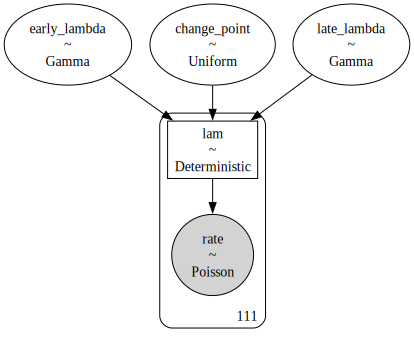

In [15]:
import pymc as pm

def coal_disaster_model():

    with pm.Model() as model:
        early_lambda = pm.Gamma('early_lambda', 1, 1)
        late_lambda = pm.Gamma('late_lambda', 1, 1)
        change_point = pm.Uniform('change_point', 1851, 1962)
        
        lam = pm.Deterministic('lam', pm.math.switch(years > change_point, late_lambda, early_lambda))
        pm.Poisson('rate', lam, observed=disasters_array)

    return model

pm.model_to_graphviz(coal_disaster_model())

### Implementing Gibbs sampling

We are interested in estimating the joint posterior of $\lambda_1$, $\lambda_2$ and $\tau$ given the array of annnual disaster counts $\mathbf{y}$. This gives:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(\mathbf{y} | \lambda_1, \lambda_2, \tau ) P(\lambda_1, \lambda_2, \tau) 
$$

To employ Gibbs sampling, we need to factor the joint posterior into the product of conditional expressions:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(y_{t<\tau} | \lambda_1, \tau) P(y_{t\ge \tau} | \lambda_2, \tau) P(\lambda_1) P(\lambda_2) P(\tau)
$$

which we have specified as:

$$\begin{aligned}
P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) &\propto \left[\prod_{t=1851}^{\tau} \text{Poi}(y_t|\lambda_1) \prod_{t=\tau+1}^{1962} \text{Poi}(y_t|\lambda_2) \right] \text{Gamma}(\lambda_1|\alpha,\beta) \text{Gamma}(\lambda_2|\alpha, \beta) \frac{1}{111} \\
&\propto \left[\prod_{t=1851}^{\tau} e^{-\lambda_1}\lambda_1^{y_t} \prod_{t=\tau+1}^{1962} e^{-\lambda_2} \lambda_2^{y_t} \right] \lambda_1^{\alpha-1} e^{-\beta\lambda_1} \lambda_2^{\alpha-1} e^{-\beta\lambda_2} \\
&\propto \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}
\end{aligned}$$

So, the full conditionals are known, and critically for Gibbs, can easily be sampled from.

$$\lambda_1 \sim \text{Gamma}(\sum_{t=1851}^{\tau} y_t +\alpha, \tau+\beta)$$
$$\lambda_2 \sim \text{Gamma}(\sum_{t=\tau+1}^{1962} y_i + \alpha, 1962-\tau+\beta)$$
$$\tau \sim \text{Categorical}\left( \frac{\lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}}{\sum_{k=1851}^{1962} \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}} \right)$$

Implementing this in Python requires random number generators for both the gamma and discrete uniform distributions. We can leverage NumPy for this:

So far so good! Now here's an implementation!

In [30]:
def gamma_pdf(lam, a, b):
    return lam**(a - 1) * np.exp(-b * lam)


def gibbs_sample_disaster(samples, tau=1900, early_lambda=6, late_lambda=2):
    """Can supply different initial conditions!"""
    draws = np.empty((3, samples))
    n_years = disasters_array.shape[0]
    years = np.arange(1851, 1962, dtype=int)
    # draws = []
    # while len(draws) < samples:
    for i in range(samples):
        # update early_lambda
        early_lambda = np.random.gamma(disasters_array[:tau - 1851].sum() + 1, 1 / (tau - 1851 + 10))
        # draws.append([early_lambda, late_lambda, tau])
        draws[0, i] = early_lambda
        
        # update late_lambda
        late_lambda = np.random.gamma(disasters_array[tau - 1851 + 1:].sum() + 1, 1 / (1962 - tau + 10))
        # draws.append([early_lambda, late_lambda, tau])
        draws[1, i] = late_lambda
        
        # update tau
        tau_probs = np.empty(n_years)
        for t in range(n_years):
            tau_probs[t] = (gamma_pdf(early_lambda, disasters_array[:t].sum() + 1, t + 10) *
                            gamma_pdf(late_lambda, disasters_array[t:].sum() + 1, n_years - t + 10))
        tau = np.random.choice(years, p=tau_probs / tau_probs.sum())
        # draws.append([early_lambda, late_lambda, tau])
        draws[2, i] = tau

    return draws #np.array(draws)[:samples]


### Checking our work

We compare the Gibbs sampler to the PyMC model -- this one runs faster, but took longer to write!

In [32]:
%%time
draws = gibbs_sample_disaster(1000)
draws.mean(axis=1) # early_lambda, late_lambda, change_point

CPU times: user 507 ms, sys: 11.9 ms, total: 519 ms
Wall time: 511 ms


array([2.47846142e+00, 8.03307933e-01, 1.89305500e+03])

In [20]:
# %%time
with coal_disaster_model() as model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [early_lambda, late_lambda, change_point]


Output()

ValueError: Not enough samples to build a trace.

In [17]:
import arviz as az

az.summary(trace, var_names=['early_lambda', 'late_lambda', 'change_point', ])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
early_lambda,3.079,0.288,2.524,3.573,0.020,0.014,203.0,426.0,1.01
late_lambda,0.944,0.119,0.737,1.171,0.008,0.006,200.0,365.0,1.01
change_point,1890.329,2.489,1885.886,1894.582,0.192,0.136,177.0,230.0,1.01


## Hamiltonian Monte Carlo

While flexible and easy to implement, Metropolis-Hastings (and Gibbs) sampling is a random walk
sampler that might not be statistically efficient for many models. Specifically, for models of high dimension, random walk jumping algorithms do not perform well. It is not enough to simply guess at the next sample location; we need to make each iteration a useful draw from the posterior whenever we can, in order to have an efficient sampler for bigger models.

Since Bayesian inference is all about calculating expectations over posteriors, what we seek is an algorithm that explores the area of the parameter space that contains most of the non-zero probability. This region is called the **typical set**.

### What's a Typical Set?

The typical set is where most of the probability density (mass) lies in a particular volume associated with the distribution. As the dimension of a model increases, this set moves progressively further from the mode, and becomes more singular, as the result of concentration of measure.

The typical set is a product of both the density, which is highest at the mode, and volume (that we integrate over), which increasingly becomes larger away from the mode as dimensionality increases. In fact, at high dimensions, the region around the mode contributes almost nothing to the expectation. We need an algorithm that will find this narrow region and explore it efficiently.

![from Hoffman and Gelman 2014](http://d.pr/i/RAA+)

In this context, and when sampling from continuous variables, Hamiltonian (or Hybrid) Monte
Carlo (HMC) can prove to be a powerful tool. It avoids
random walk behavior by simulating a physical system governed by
Hamiltonian dynamics, potentially avoiding tricky conditional
distributions in the process.

In HMC, model samples are obtained by simulating a physical system,
where particles move about a high-dimensional landscape, subject to
potential and kinetic energies. Adapting the notation from [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html),
particles are characterized by a position vector or state
$s \in \mathcal{R}^D$ and velocity vector $\phi \in \mathcal{R}^D$. The
combined state of a particle is denoted as $\chi=(s,\phi)$. 

The joint **canonical distribution** of the position and velocity can be expressed as a product of the marginal position (which is of interest) and the conditional distribution of the velocity:

$$\pi(s, \phi) = \pi(\phi | s) \pi(s)$$

This joint probability can also be written in terms of an invariant **Hamiltonian function**:

$$\pi(s, \phi) \propto \exp(-H(s,\phi))$$

The Hamiltonian is then defined as the sum of potential energy $E(s)$ and kinetic energy
$K(\phi)$, as follows:

$$\mathcal{H}(s,\phi) = E(s) + K(\phi)
= E(s) + \frac{1}{2} \sum_i \phi_i^2$$

Instead of sampling $p(s)$ directly, HMC operates by sampling from the canonical distribution.

$$p(s,\phi) = \frac{1}{Z} \exp(-\mathcal{H}(s,\phi))=p(s)p(\phi)$$

If we choose a momentum that is independent of position, marginalizing over $\phi$ is
trivial and recovers the original distribution of interest.

Note that the Hamiltonian $\mathcal{H}$ is independent of the parameterization of the model, and therefore, captures the geometry of the phase space distribution, including typical set. 

**Hamiltonian Dynamics**

State $s$ and velocity $\phi$ are modified such that
$\mathcal{H}(s,\phi)$ remains constant throughout the simulation. The
differential equations are given by:

$$\begin{aligned}\frac{ds_i}{dt} &= \frac{\partial \mathcal{H}}{\partial \phi_i} = \phi_i \\
\frac{d\phi_i}{dt} &= - \frac{\partial \mathcal{H}}{\partial s_i}
= - \frac{\partial E}{\partial s_i}
\end{aligned}$$

As shown in [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), 
the above transformation preserves volume and is
reversible. The above dynamics can thus be used as transition operators
of a Markov chain and will leave $p(s,\phi)$ invariant. That chain by
itself is not ergodic however, since simulating the dynamics maintains a
fixed Hamiltonian $\mathcal{H}(s,\phi)$. HMC thus alternates Hamiltonian
dynamic steps, with Gibbs sampling of the velocity. Because $p(s)$ and
$p(\phi)$ are independent, sampling $\phi_{new} \sim p(\phi|s)$ is
trivial since $p(\phi|s)=p(\phi)$, where $p(\phi)$ is often taken to be
the univariate Gaussian.

![Skate park](images/skate_park.png?raw=true)

**The Leap-Frog Algorithm**

In practice, we cannot simulate Hamiltonian dynamics exactly because of
the problem of time discretization. There are several ways one can do
this. To maintain invariance of the Markov chain however, care must be
taken to preserve the properties of *volume conservation* and *time
reversibility*. The **leap-frog algorithm** maintains these properties
and operates in 3 steps:

$$\begin{aligned}
\phi_i(t + \epsilon/2) &= \phi_i(t) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\phi_i(t + \epsilon) &= \phi_i(t + \epsilon/2) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + \epsilon)) 
\end{aligned}$$

We thus perform a half-step update of the velocity at time
$t+\epsilon/2$, which is then used to compute $s(t + \epsilon)$ and
$\phi(t + \epsilon)$.

**Accept / Reject**

In practice, using finite stepsizes $\epsilon$ will not preserve
$\mathcal{H}(s,\phi)$ exactly and will introduce bias in the simulation.
Also, rounding errors due to the use of floating point numbers means
that the above transformation will not be perfectly reversible.

HMC cancels these effects **exactly** by adding a Metropolis
accept/reject stage, after $n$ leapfrog steps. The new state
$\chi' = (s',\phi')$ is accepted with probability $p_{acc}(\chi,\chi')$,
defined as:

$$p_{acc}(\chi,\chi') = min \left( 1, \frac{\exp(-\mathcal{H}(s',\phi')}{\exp(-\mathcal{H}(s,\phi)} \right)$$

**HMC Algorithm**

We obtain a new HMC sample as follows:

1.  sample a new velocity from a univariate Gaussian distribution
2.  perform $n$ leapfrog steps to obtain the new state $\chi'$
3.  perform accept/reject move of $\chi'$

## MCMC in PyMC

PyMC's core business is using Markov chain Monte Carlo to fit virtually any probability model. This involves the assignment and coordination of a suite of **step methods**, each of which is responsible for updating one or more variables. 

The user's interface to PyMC's sampling algorithms is the `sample` function:

```python
pm.sample(
    draws: int = 1000,
    *,
    tune: int = 1000,
    chains: Optional[int] = None,
    cores: Optional[int] = None,
    random_seed: Union[int, Sequence[int], numpy.ndarray, NoneType, numpy.random.mtrand.RandomState, numpy.random._generator.Generator] = None,
    progressbar: bool = True,
    step=None,
    nuts_sampler: str = 'pymc',
    initvals: Union[Dict[Union[pytensor.graph.basic.Variable, str], Union[numpy.ndarray, pytensor.graph.basic.Variable, str]], Sequence[Optional[Dict[Union[pytensor.graph.basic.Variable, str], Union[numpy.ndarray, pytensor.graph.basic.Variable, str]]]], NoneType] = None,
    init: str = 'auto',
    jitter_max_retries: int = 10,
    n_init: int = 200000,
    trace: Optional[pymc.backends.base.BaseTrace] = None,
    discard_tuned_samples: bool = True,
    compute_convergence_checks: bool = True,
    keep_warning_stat: bool = False,
    return_inferencedata: bool = True,
    idata_kwargs: Optional[Dict[str, Any]] = None,
    nuts_sampler_kwargs: Optional[Dict[str, Any]] = None,
    callback=None,
    mp_ctx=None,
    model: Optional[pymc.model.Model] = None,
    **kwargs,
) -> Union[arviz.data.inference_data.InferenceData, pymc.backends.base.MultiTrace]
```

`sample` assigns particular samplers to model variables, and generates samples from them. The `draws` argument
controls the total number of MCMC iterations. PyMC can automate most of the details of sampling, outside of the selection of the number of draws, using default settings for several parameters that control how the sampling is set up and conducted. However, users may manually intervene in the specification of the sampling by passing values to a number of keyword argumetns for `sample`.

### Assigning step methods

The `step` argument allows users to assign a MCMC sampling algorithm to the entire model, or to a subset of the variables in the model. For example, if we wanted to use the Metropolis-Hastings sampler to fit our model, we could pass an instance of that step method to `sample` via the `step` argument:

```python
with my_model:

    trace = pm.sample(1000, step=pm.Metropolis())
```

or if we only wanted to assign `Metropolis` to a parameter called `beta`:

```python
with my_model:

    trace = pm.sample(1000, step=pm.Metropolis(vars=[beta]))
```

Step method classes handle individual stochastic variables, or sometimes groups of them. They are responsible for making the variables they handle take **single MCMC steps** conditional on the rest of the model. Each PyMC step method (usually subclasses of `ArrayStep`) implements a method called `astep()`, which is called iteratively by `sample`. 

All step methods share an optional argument `vars` that allows a particular subset of variables to be handled by the step method instance. Particular step methods will have additional arguments for setting parameters and preferences specific to that sampling algorithm.

> NB: when a PyMC function or method has an argument called `vars` it is expecting a list of variables (*i.e.* the variables themselves), whereas arguments called `var_names` expect a list of variables names (*i.e.* strings)

#### HamiltonianMC

The Hamiltonian Monte Carlo algorithm is implemented in the `HamiltonianMC` class. Being a gradient-based sampler, it is only suitable for **continuous random variables**. Several optional arguments can be provided by the user. The algorithm is **non-adaptive**, so the parameter values passed at instantiation are fixed at those values throughout sampling.

`HamiltonianMC` requires a scaling matrix parameter `scaling`, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although it is used somewhat differently here. The matrix gives an approximate shape of the posterior distribution, so that `HamiltonianMC` does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. 

Fortunately, `HamiltonianMC` can often make good guesses for the scaling parameters. If you pass a point in parameter space (as a dictionary of variable names to parameter values, the same format as returned by `find_MAP`), it will look at the **local curvature** of the log posterior-density (the diagonal of the Hessian matrix) at that point to guess values for a good scaling vector, which can result in a good scaling value. Also, the MAP estimate is often a good point to use to initiate sampling. 

- `scaling` 
: Scaling for momentum distribution. If a 1-dimensional array is passed, it is interpreted as a matrix diagonal.
            
- `step_scale` 
: Size of steps to take, automatically scaled down by $1/n^{0.25}$. Defaults to .25.
            
- `path_length` 
: total length to travel during leapfrog. Defaults to 2.
            
- `is_cov` 
: Flag for treating scaling as a covariance matrix/vector, if True. Treated as precision otherwise.
            
- `step_rand` 
: A function which takes the step size and returns an new one used to randomize the step size at each iteration.


#### NUTS

`NUTS` is the No U-turn Sampler of Hoffman and Gelman (2014), an adaptive version of Hamiltonian MC that **automatically tunes** the step size and number on the fly. 

In addition to the arguments to `HamiltonianMC`, `NUTS` takes additional parameters to controls the tuning. The most important of these is the target acceptance rate for the Metropolis acceptance phase of the algorithm, `target_accept`. 
Sometimes if the NUTS struggles to sample efficiently, changing this parameter above the default target rate of 0.8 will improve sampling (the original recommendation by Hoffman & Gelman was 0.6). Increasing the rate very high will also make the sampler more conservative, however, taking many small steps at every iteration. 

In [22]:
with model:
    trace_90 = pm.sample(1000, tune=2000, target_accept=0.9)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [early_lambda, late_lambda, change_point]


Output()

ValueError: Not enough samples to build a trace.

In [ ]:
trace_90.sample_stats['acceptance_rate'].mean()

There is rarely a reason to use `HamiltonianMC` rather than `NUTS`. It is the default sampler for continuous variables in PyMC.

### Metropolis

``Metropolis`` implements a Metropolis-Hastings step, as described the theory section, and is designed to handle float- and integer-valued variables.

A `Metropolis` step method can be instantiated with any of several optional arguments:

- `S`
:   This sets the proposal standard deviation or covariance matrix.

- `proposal_dist`
:   A function that generates zero-mean random deviates used as proposals. Defaults to the normal distribution.

- `scaling`
:   An initial scale factor for the proposal

- `tune_interval`
:   The number of intervals between tuning updates to `scaling` factor.

When the step method is instantiated, the `proposal_dist` is parameterized with the value passed for `S`. While sampling, the value of `scaling` is used to scale the value proposed by `proposal_dist`, and this value is tuned throughout the MCMC run. During tuning, the acceptance ratio of the step method is examined, and this scaling factor
is updated accordingly. Tuning only occurs when the acceptance rate is **lower than 20%** or **higher than 50%**; rates between 20-50% are considered optimal for Metropolis-Hastings sampling. The default tuning interval (`tune_interval`) is 100 iterations.

Although tuning will continue throughout the sampling loop, it is important to verify that the
**diminishing tuning** condition of [Roberts and Rosenthal (2007)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.jap/1183667414) is satisfied: the
amount of tuning should decrease to zero, or tuning should become very infrequent.

`Metropolis` handles discrete variable types automatically by rounding the proposed values and casting them to integers.

### BinaryMetropolis

While binary (boolean) variables can be handled by the `Metropolis` step method, sampling will be very inefficient. The `BinaryMetropolis` class is optimized to handle binary variables, by one of only two possible values. The only tuneable parameter is the `scaling` argument, which is used to vary the Bernoulli probability:

    p_jump = 1. - .5 ** self.scaling

This value is compared to pseudo-random numbers generated by the step method, to determine whether a 0 or 1 is proposed.

`BinaryMetropolis` will be automatically selected for random variables that are distributed as Bernoulli, or categorical with only 2 categories.

PyMC also includes implementations of the slice sampler (Neal 2003), stochastic gradient Markov chain Monte Carlo (SGMCMC, Nemeth & Fearnhead 2019) and Multi-Level Delayed Acceptance MCMC (MLDA, Dodwell et al. 2019), which we will not cover here. 

### Automatic assignment of step methods

When `step` is not specified by the user, PyMC will assign step methods to variables automatically. To do so, each step method implements a class method called `Competence`. This method returns a value from 0 (incompatible) to 3 (ideal), based on the attributes of the random variable in question. `sample()` assigns the step method that returns the highest competence value to each of its unallocated stochastic random variables. In general:

* Binary variables will be assigned to `BinaryMetropolis` (Metropolis-Hastings for binary values)
* Discrete variables will be assigned to `Metropolis`
* Continuous variables will be assigned to `NUTS` (No U-turn Sampler)

### Starting values

The `initvals` argument allows for the specification of starting values for stochastic random variables in the model. MCMC algorithms begin by initializing all unknown quantities to arbitrary starting values. Though in theory the value can be any value under the support of the distribution describing the random variable, we can make sampling more difficult if an initial value is chosen in the extreme tail of the distribution, for example. If starting values are not passed by the user, default values are chosen from the mean, median or mode of the distribution.

It is sometimes (but not always) useful to initialize a MCMC simulation at the maximum *a posteriori* (MAP) estimate:

In [23]:
with model:
    
    posterior_mode = pm.find_MAP()

posterior_mode

Output()

{'early_lambda_log__': array(0.90570837),
 'late_lambda_log__': array(-0.11332819),
 'change_point_interval__': array(0.),
 'early_lambda': array(2.47368359),
 'late_lambda': array(0.89285758),
 'change_point': array(1906.5),
 'lam': array([2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359, 2.47368359, 2.47368359, 2.47368359, 2.47368359,
        2.47368359,

In [25]:
with model:
    trace = pm.sample(100, step=pm.Metropolis(), cores=2, initvals=posterior_mode)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [early_lambda]
>Metropolis: [late_lambda]
>Metropolis: [change_point]


Output()

Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


If we are sampling more than one Markov chain from our model, it is often recommended to initialize each chain to different starting values, so that lack of convergence can be more easily detected (see *Model Checking* section). 

### Storing samples

Notice in the above call to `sample` that output is assigned to a variable we have called `trace`. 

In [26]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

This `InferenceData` object is a data structure that stores the samples from an MCMC run as grouped attributes. The data structure itself is an `xarray.Dataset` object, which is a dictionary-like object that stores the samples in a multi-dimensional array.

The xarray components include:

- **Data variables** are the actual values generated from the MCMC draws
- **Dimensions** are the axes on which refer to the data variables
- **Coordinates** are pointers to specific slices or points in the `xarray.Dataset`

### Parallel sampling

Nearly all modern desktop computers have multiple CPU cores, and running multiple MCMC chains is an **embarrasingly parallel** computing task. It is therefore relatively simple to run chains in parallel in PyMC. This is done by setting the `cores` argument in `sample` to some value between 2 and the number of cores on your machine (you can specify more chains than cores, but you will not gain efficiency by doing so). The default value of `cores` is `None`, which will select the number of CPUs on your machine, to a maximum of 4. 

> Keep in mind that some chains might themselves be multithreaded via openmp or BLAS. In those cases it might be faster to set this to 1.

By default, PyMC will run a sample a minimum of 2 and a maximum of `cores` chains. However, the number of chains sampled can be set independently of the number of cores by specifying the `chains` argument.

```python
with test_score_model:
    trace = pm.sample(chains=4, cores=2)
```

Running $n$ iterations with $c$ chains will result in $c \times n$ samples.

Generating several chains is generally recommended because it aids in model checking, allowing statistics such as the potential scale reduction factor ($\hat{R}$) and effective sample size to be calculated.

### Exercise: Coal mining disasters

Let's return to the coal mining disasters example from the previous section. Recall that we are interested in estimating the annyal rate of disasters, where there is thought to be a rate change at some point in the time series.

Here again is the model:

$$
y_t \sim \operatorname{Poisson}(\lambda_t), t=1851, \ldots, 1962 \\
\lambda_t = \left\{ \begin{array}{}\lambda_1 \text{ for } t \leq \tau \\ \lambda_2 \text{ for } t > \tau \end{array}\right. \\
\lambda_j \sim \operatorname{Gamma}(1, 10) \\
\tau \sim \operatorname{DiscreteUniform}(1851, 1962)
$$

And an implementation in PyMC:

In [ ]:
disasters_array = np.array(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 
     1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 
     1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 
     0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 
     1, 2, 4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 
     1])
years = np.arange(1851, 1962, dtype=int)

with pm.Model() as model:
    early_lambda = pm.Gamma('early_lambda', 1, 0.1)
    late_lambda = pm.Gamma('late_lambda', 1, 0.1)
    change_point = pm.Uniform('change_point', 1851, 1962)
    
    lam = pm.Deterministic('lam', pm.math.switch(years > change_point, late_lambda, early_lambda))
    pm.Poisson('rate', lam, observed=disasters_array)

Use `pm.sample` to draw 1000 samples, using the default step method assigned by PyMC. Then experiment with different step methods and observe the effect on sampling.

In [ ]:
# Write your answer here

## JAX-based Samplers

An alternative to PyMC's PyTensor-based samplers are samplers written in JAX. Using these samplers, all the operations needed to compute a posterior can be performed under JAX, reducing the Python overhead during sampling and leveraging all JAX performance improvements and features like the ability to sample on GPUs or TPUs.

PyMC offers NUTS JAX samplers via [NumPyro](https://num.pyro.ai/en/latest/index.html) or [BlackJAX](https://blackjax-devs.github.io/blackjax/). Significantly, BlackJAX and NumPyro can both be used because in PyMC the modeling language is decoupled from the inference methods; BlackJAX and NumPyro only require a log-probability density function written in JAX. This demonstrates that samplers can be developed independently of PyMC and then be made available to users of the library.

The JAX samplers can be invoked using the `nuts_sampler` argument for `pm.sample`:

```python
pm.sample(nuts_sampler="numpyro")
```

### Exercise: Speed test

Compare the speed of the JAX samplers to the PyTensor samplers using the coal mining disasters model above. 

HINT: You can use the `%%time` magic command to time the execution of a cell.

ANOTHER HINT: You may need to reparameterize the model to use the JAX samplers.

ALSO: If you don't have `numpyro` installed, you need to do that first.

In [27]:
with model:
    trace = pm.sample(nuts_sampler='numpyro')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


---
## References

Doucet, A., De Freitas, N., and Gordon, N. (2001), Sequential Monte Carlo Methods in Practice, Statistics for Engineering and Information Science, New York: Springer-Verlag.

Chapter 6 of [Givens, Geof H.; Hoeting, Jennifer A. (2012-10-09). Computational Statistics (Wiley Series in Computational Statistics)](http://www.stat.colostate.edu/computationalstatistics/)

Chapter 5 of [Albert, J. (2009). Bayesian computation with R.](http://www.amazon.com/Bayesian-Computation-R-Use/dp/0387922970)

Gelman, A., Carlin, J. B., Stern, H. S., & Rubin, D. B. (2003). Bayesian Data Analysis, Second Edition (Chapman & Hall/CRC Texts in Statistical Science) (2nd ed.). Chapman and Hall/CRC.

Neal, R. M. (2003). Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198